In [1]:
push!(LOAD_PATH, "..")
using ASE
# using MatSciPy
using PyPlot
using PyCall
import TightBinding

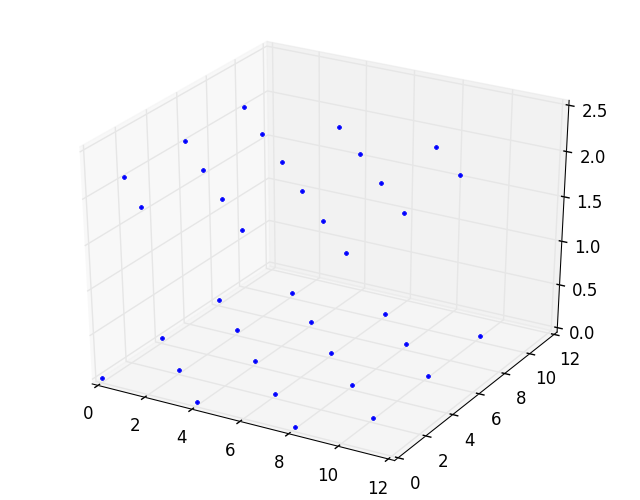

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x4458410>

In [2]:
at = bulk("Al"; cubic=true)
at = repeat(at, (3, 3, 1))
X = positions(at)
set_pbc!(at, (false, false, false))
plot3D(X[1,:][:], X[2,:][:], X[3,:][:], "b.")


In [11]:
reload("Potentials")
reload("tbtoymodel")
reload("TightBinding")
reload("MatSciPy")
tbm = TightBinding.ToyTB.ToyTBModel(r0=2.5, rcut=6.0)
E = TightBinding.potential_energy(at, tbm)
println("E = ", E)
frc = TightBinding.forces(at, tbm)
println("|f|∞ = ", norm(frc[:], Inf))

E = -

13.838707030077073
|f|∞ = 132279.52650409297
